# 3. Building and evaluating different models

#### Procedure
- Training data set (which has been embedded) will be run on different models 

Models to build:
- a dummy model: mean of y
- a baseline model: using only gender
- "full" models (including all predictors):
    - a simple linear regression
    - a non-parametric linear regression; KNN
    - a random forrest regressor

I expect that the data should be heavily regularized. I'll take care of that when I've found the most promising model. 

When the 'winning' model has been regularized and fine-tuned using cross-validation, the model will be tested on the validation set.

Then the model can be further tuned, before it is finally run on the test data set, and the results are reported.


In [1]:
# important packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error # MSE?? rmse? 
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge

## random forrest og feature importance 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
#from xgboost import XGBRegressor
import pickle as pkl
import shap


/work/datascience_exam/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load data which has been embedded, clustered and dimensionality reduced using PCA
train = pd.read_csv('/work/datascience_exam/data/train_features.csv', index_col = 0)

In [3]:
X_train = train.iloc[:,:237] # all columns but the last one which is 'Age of Death'
y_train = train.loc[:,'Age of death']

In [4]:
X_train.head()

,Gender_encode,Birth year,Occupation_cluster,country1,country2,country3,country4,country5,country6,country7,...,description143,description144,description145,description146,description147,description148,description149,description150,description151,description152
0,2,1915,1,-0.203594,-0.144200,0.094234,-0.186961,0.011282,-0.267115,0.042559,...,-0.002223,0.031173,-0.015610,0.021765,-0.043946,-0.055602,0.099160,0.005596,0.025316,0.010624
1,1,1915,0,-0.201265,-0.031549,0.048032,-0.224219,-0.395700,0.084482,-0.024386,...,0.010041,-0.029504,-0.007824,0.001081,0.023954,-0.006589,-0.006589,0.017155,-0.019700,-0.009435
2,1,1923,0,-0.273769,-0.121739,-0.152663,0.409265,-0.110530,0.146183,0.105975,...,-0.003499,0.002186,0.005657,0.013795,0.006256,-0.000399,0.004402,-0.004409,0.008620,0.000956
3,1,1918,2,-0.349983,-0.160185,-0.229322,-0.122732,0.266424,0.049163,-0.095842,...,0.011873,0.013108,-0.010277,-0.005705,0.001044,-0.009338,0.039861,0.008489,-0.014900,-0.028253
4,1,1856,3,-0.029722,0.303856,0.063169,-0.040947,0.083048,-0.158634,0.014466,...,0.027537,-0.052587,-0.002195,0.020234,0.008825,-0.071778,0.031260,0.011545,0.020523,0.016538


## Standardizing embedded features - is that what we want to do?

In [ ]:
# standardize embedded data
scaler = StandardScaler()

X_train_scaled.loc[:,'occupation1':] = scaler.fit_transform(X_train.iloc[:,'occupation1':])

In [ ]:
# standardize embedded data
scaler = StandardScaler()
#X_train_pred_scaled = scaler.fit_transform(X_train_predictors[:,3:])

# pd version
#>>> dfTest[['A', 'B']] = scaler.fit_transform(dfTest[['A', 'B']])

X_train.iloc[:,3:51] = scaler.fit_transform(X_train.iloc[:,3:51])
X_train

In [ ]:
#_train_predictors_scaled = np.hstack((non_scaled_cols, X_train_pred_scaled))

## Building models

I want to build the following models:

- Model 1: A 'dummy' model with only the mean of y as feature
- Model 2: A 'baseline' model with only one feature (here, 'gender')
- Model 3: The full model which includes all predictors. 

Model 1 and 2 will be modelled as a linear regression. 

Model 3 will be modelled as a linear regression, KNN-regression and a random forrest.

In [5]:
performances = []

In [4]:
### Dummy model - PD version

mean_value = y_train.mean()
model_name = 'dummy'
performance = np.sqrt(mean_squared_error(y_train, [mean_value]*len(y_train)))
r2 = r2_score(y_train, [mean_value]*len(y_train))
performances.append({'model': model_name,
                     'split': 'train',
                     'rmse': performance.round(4),
                     'r2': r2.round(4)})

In [5]:
### Baseline model - only predictor is gender - linear regression - PD version

gender = X_train.loc[:, ['Gender_encode']]
reg = LinearRegression().fit(gender, y_train)

preds =  reg.predict(gender)
r2 = r2_score(y_train, preds)
performance = np.sqrt(mean_squared_error(y_train, preds))
performances.append({'model': 'linear-gender',
                         'split': 'train',
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

In [6]:
birth_year = X_train.loc[:, ['Birth year']]
reg = LinearRegression().fit(birth_year, y_train)

preds =  reg.predict(birth_year)
r2 = r2_score(y_train, preds)
performance = np.sqrt(mean_squared_error(y_train, preds))
performances.append({'model': 'linear-birth_year',
                        'split': 'train',
                        'rmse': performance.round(4),
                        'r2': r2.round(4)})

In [7]:
### full linear model --- PANDAS VERSION
# cv? - this is not working out 
# regularization? 

reg = LinearRegression().fit(X_train, y_train)

preds =  reg.predict(X_train)
r2 = r2_score(y_train, preds)
performance = np.sqrt(mean_squared_error(y_train, preds))
performances.append({'model': 'linear-full',
                         'split': 'train',
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

In [8]:
# linear lasso

reg = Lasso().fit(X_train, y_train)

preds = reg.predict(X_train)
r2 = r2_score(y_train, preds)
performance = np.sqrt(mean_squared_error(y_train, preds))
performances.append({'model': 'linear_lasso_alpha_1.0',
                         'split': 'train',
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

In [9]:
# linear ridge

reg = Ridge().fit(X_train, y_train)

preds = reg.predict(X_train)
r2 = r2_score(y_train, preds)
performance = np.sqrt(mean_squared_error(y_train, preds))
performances.append({'model': 'linear_ridge_alpha_1.0',
                         'split': 'train',
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

In [10]:
k = 10
neigh = KNeighborsRegressor(n_neighbors=k)
neigh.fit(X_train, y_train)
#pkl.dump(neigh, file=open(f'example-models/knn-allpreds-{k}.pkl', 'wb')) # save the model

preds = neigh.predict(X_train)

r2 = r2_score(y_train, preds)
performance = np.sqrt(mean_squared_error(y_train, preds))
performances.append({'model': f'knn-allpreds-{k}',
                        'split': 'train',
                        'rmse': performance.round(4),
                        'r2': r2.round(4)})

In [21]:
# randomforest model with default parameter values - # 255 min in ucloud with all features

rfreg = RandomForestRegressor(random_state=42)
rfreg.fit(X_train, y_train) # first, we instantiate the estimator

preds = rfreg.predict(X_train)
r2 = r2_score(y_train, preds)
performance = np.sqrt(mean_squared_error(y_train, preds))
performances.append({'model': 'rfr_default',
                        'split': 'train',
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

In [22]:
# save model 
#pkl.dump(rfreg, file=open(f'/work/datascience_exam/output/models/rfr_default_all_features.pkl', 'wb')) # save the model

In [6]:
# reload model 
rfreg = pkl.load(open('/work/datascience_exam/output/models/rfr_default_all_features.pkl','rb'))

In [69]:
# how to read df into a dictionary
df = pd.read_csv('/work/datascience_exam/output/models/model_performances_v3.csv', index_col = 0)

# make into list format
performances2 = []

for index, row in df.iterrows():
    row_dict = {}
    for col in df.columns:
        row_dict[col] = row[col]
    performances2.append(row_dict)

print(*performances2, sep = '\n')

{'model': 'dummy', 'split': 'train', 'rmse': 15.937, 'r2': 0.0}
{'model': 'linear-gender', 'split': 'train', 'rmse': 15.918, 'r2': 0.0024}
{'model': 'linear-birth_year', 'split': 'train', 'rmse': 15.7883, 'r2': 0.0186}
{'model': 'linear-full', 'split': 'train', 'rmse': 15.3054, 'r2': 0.0777}
{'model': 'linear_lasso_alpha_1.0', 'split': 'train', 'rmse': 15.7883, 'r2': 0.0186}
{'model': 'linear_ridge_alpha_1.0', 'split': 'train', 'rmse': 15.3054, 'r2': 0.0777}
{'model': 'knn-allpreds-10', 'split': 'train', 'rmse': 13.2382, 'r2': 0.31}
{'model': 'rfr_default', 'split': 'train', 'rmse': 7.4042, 'r2': 0.7842}
{'model': 'rfr_default_58_features', 'split': 'train', 'rmse': 7.4126, 'r2': 0.7837}
{'model': 'rfr_tuned_58_features', 'split': 'train', 'rmse': 13.7861, 'r2': 0.2517}


Looks like random forest wins! Note, that was the default version with no stopping parameters, which means it most likely is overfitting the data.

Also, the model took a very long time to run (255 min, strongest machine on ucloud) because of the many features.

So, before we move on to tuning (and regularizing) the model, I'll look at feature importances and see if I can do some feature selection. 

In [28]:
# get feature importances from the model
importances = rfreg.feature_importances_
importances.shape

(237,)

In [29]:
feature_names = X_train.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})


In [30]:
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
top_n = 50  # Adjust this number based on how many features you want to plot
top_features = feature_importances.head(top_n)


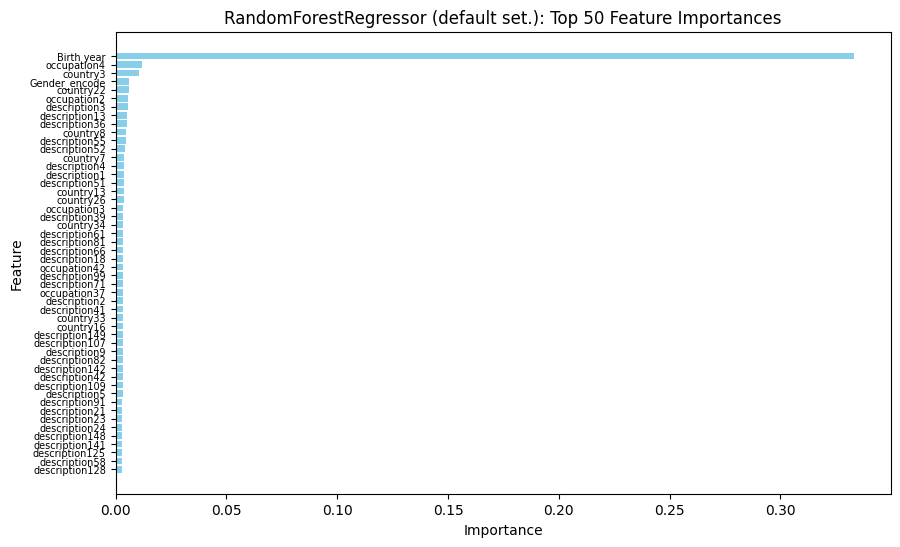

In [32]:
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.yticks(fontsize = 7)
plt.title(f'RandomForestRegressor (default set.): Top {top_n} Feature Importances')
plt.gca().invert_yaxis()
fig = plt.gcf()
plt.show()

In [33]:
fig.savefig('/work/datascience_exam/output/plots/rfr_feature_importances_full_default.jpg')

In [34]:
# We'll only keep relevant features in the model, so we are setting a threshold of 'importance'
selected_features = feature_importances[feature_importances['Importance'] > 0.003] # this is very low threshold
selected_features.shape


(58, 2)

In [70]:
#selected_features.to_csv('/work/datascience_exam/output/models/selected_features_importances.csv')

In [11]:
#selected_features = pd.read_csv('/work/datascience_exam/output/models/selected_features_importances.csv', index_col=0)

In [35]:
features_to_keep = selected_features['Feature'].tolist()

In [36]:
# Filter that from X_train
X_train_filtered = X_train[features_to_keep]
X_train_filtered.shape

(510302, 58)

In [17]:
X_train_filtered.to_csv('/work/datascience_exam/data/X_train_filtered.csv', index=False)

In [18]:
# We'll now fit the X_train_filtered to the default random forrest model. I expect that the performance won't be as good as with all the features.
# randomforest model with default parameter values - after feature selection # 64 min

rfreg_58_features = RandomForestRegressor(random_state=42)
rfreg_58_features.fit(X_train_filtered, y_train) 

preds = rfreg_58_features.predict(X_train_filtered)
r2 = r2_score(y_train, preds)
performance = np.sqrt(mean_squared_error(y_train, preds))
performances.append({'model': 'rfr_default_58_features',
                        'split': 'train',
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

In [19]:
# save model 
pkl.dump(rfreg_58_features, file=open(f'/work/datascience_exam/output/models/rfr_default_58_features.pkl', 'wb')) # save the model

In [63]:
# reload model
rfreg_58_features = pkl.load(open('/work/datascience_exam/output/models/rfr_default_58_features.pkl','rb'))

In [37]:
print(*performances2, sep = '\n')

{'model': 'dummy', 'split': 'train', 'rmse': 15.937, 'r2': 0.0}
{'model': 'linear-gender', 'split': 'train', 'rmse': 15.918, 'r2': 0.0024}
{'model': 'linear-birth_year', 'split': 'train', 'rmse': 15.7883, 'r2': 0.0186}
{'model': 'linear-full', 'split': 'train', 'rmse': 15.3054, 'r2': 0.0777}
{'model': 'linear_lasso_alpha_1.0', 'split': 'train', 'rmse': 15.7883, 'r2': 0.0186}
{'model': 'linear_ridge_alpha_1.0', 'split': 'train', 'rmse': 15.3054, 'r2': 0.0777}
{'model': 'knn-allpreds-10', 'split': 'train', 'rmse': 13.2382, 'r2': 0.31}
{'model': 'rfr_default', 'split': 'train', 'rmse': 7.4042, 'r2': 0.7842}
{'model': 'rfr_default_58_features', 'split': 'train', 'rmse': 7.4126, 'r2': 0.7837}


The model's performance almost didn't decrease even though I removed many of the features. 

I'll now make randomized search cross-validation to explore the best combination of parameters while 

constraining the model by introducing 'stopping' parameters. 

This will probably reveal that the only reason that the model has such a high r^2 is because of overfitting.

First I'll look at the default parameters of the random forrest model. 


{'n_estimators': 100,
 'min_samples_split': 5,
 'max_features': 0.6,
 'max_depth': 10,
 'ccp_alpha': 0.01}

Default parameters:
- 'bootstrap': True,
- 'criterion': 'mse',
- 'max_depth': None,
- 'max_features': 'auto',
- 'max_leaf_nodes': None,
- 'min_impurity_decrease': 0.0,
- 'min_impurity_split': None,
- 'min_samples_leaf': 1,
- 'min_samples_split': 2,
- 'min_weight_fraction_leaf': 0.0,
- 'n_estimators': 10, # default only used 10 trees
- 'n_jobs': 1,
- 'oob_score': False,
- 'random_state': 42,
- 'verbose': 0,
- 'warm_start': False}

In [39]:
# here put full random forrest model 
rfreg_cv = RandomForestRegressor(random_state=42) # first, we instantiate the estimator

In [40]:
param_grid = { 
    'n_estimators': [5, 10, 20, 100, 200], # number of trees - deafult is 100
    'max_depth' : [5, 10, 15, 20], # max number of splits/leaves (leaf = node without children) - stopping criteria # default is none
    'min_samples_split': [2, 5, 10], # min. number of samples required to split an internal node, default is 2
    'max_features': [0.3, 0.6, 0.9], # proportion of features to max. use in a tree (subset proportion) - default is 1.0 (= all features)
    'ccp_alpha': [0.01, 0.1, 1.0] # minimal-cost complexity pruning - to overvoid overfitting, default 0.0
}

In [41]:
# cv - ~90 min 
cv_rfr = RandomizedSearchCV(estimator=rfreg_cv, # I am choosing RandomizedSearchCV for speed
                            param_distributions=param_grid,
                            scoring='neg_root_mean_squared_error', # this is "neg" because CV wants a metric to maximize
                            n_iter=10, # this should more likely be above 100, and in general the higher the better
                            cv=5,
                            verbose = 2,
                            n_jobs = -1)

randomized_search = cv_rfr.fit(X_train_filtered, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ccp_alpha=1.0, max_depth=5, max_features=0.3, min_samples_split=2, n_estimators=10; total time=  30.3s
[CV] END ccp_alpha=1.0, max_depth=5, max_features=0.3, min_samples_split=2, n_estimators=10; total time=  39.7s
[CV] END ccp_alpha=1.0, max_depth=5, max_features=0.3, min_samples_split=2, n_estimators=10; total time=  39.6s
[CV] END ccp_alpha=1.0, max_depth=5, max_features=0.3, min_samples_split=2, n_estimators=10; total time=  40.2s
[CV] END ccp_alpha=1.0, max_depth=5, max_features=0.3, min_samples_split=2, n_estimators=10; total time=  40.2s
[CV] END ccp_alpha=0.01, max_depth=5, max_features=0.3, min_samples_split=5, n_estimators=20; total time=  57.2s
[CV] END ccp_alpha=0.01, max_depth=5, max_features=0.3, min_samples_split=5, n_estimators=20; total time= 1.1min
[CV] END ccp_alpha=0.01, max_depth=5, max_features=0.3, min_samples_split=5, n_estimators=20; total time= 1.1min
[CV] END ccp_alpha=0.01, max_depth=5, ma

In [42]:
# save 
pkl.dump(randomized_search, file=open(f'/work/datascience_exam/output/models/randomized_search_cv_58_features.pkl', 'wb')) # save the model

In [9]:
# re-load model 
# Loading model to compare the results
randomized_search= pkl.load(open('/work/datascience_exam/output/models/randomized_search_cv_58_features.pkl','rb'))

In [ ]:
randomized_search.cv_results_

In [46]:
randomized_search.best_params_

{'n_estimators': 200,
 'min_samples_split': 10,
 'max_features': 0.9,
 'max_depth': 10,
 'ccp_alpha': 0.01}

The model maximizes the number of trees, but doesn't maximize tree depth. 
min_smaples_split is also maximized, which should reduce overfitting.
almost all features are used in a tree 
ccp_alpha should maybe be higher.. 

Now we want to run the tuned model on the training data again

In [52]:
cv_rfr_tuned = randomized_search.best_estimator_ # has already been fitted

preds = cv_rfr_tuned.predict(X_train_filtered)
r2 = r2_score(y_train, preds)
performance = np.sqrt(mean_squared_error(y_train, preds))
performances.append({'model': 'rfr_tuned_58_features', 
                        'split': 'train',
                        'rmse': performance.round(4),
                        'r2': r2.round(4)})

In [53]:
pkl.dump(cv_rfr_tuned, file=open(f'/work/datascience_exam/output/models/cv_rfr_tuned_58_features.pkl', 'wb')) # save the model

In [65]:
print(*performances, sep = '\n')

{'model': 'dummy', 'split': 'train', 'rmse': 15.937, 'r2': 0.0}
{'model': 'linear-gender', 'split': 'train', 'rmse': 15.918, 'r2': 0.0024}
{'model': 'linear-birth_year', 'split': 'train', 'rmse': 15.7883, 'r2': 0.0186}
{'model': 'linear-full', 'split': 'train', 'rmse': 15.3054, 'r2': 0.0777}
{'model': 'linear_lasso_alpha_1.0', 'split': 'train', 'rmse': 15.7883, 'r2': 0.0186}
{'model': 'linear_ridge_alpha_1.0', 'split': 'train', 'rmse': 15.3054, 'r2': 0.0777}
{'model': 'knn-allpreds-10', 'split': 'train', 'rmse': 13.2382, 'r2': 0.31}
{'model': 'rfr_default', 'split': 'train', 'rmse': 7.4042, 'r2': 0.7842}
{'model': 'rfr_default_58_features', 'split': 'train', 'rmse': 7.4126, 'r2': 0.7837}
{'model': 'rfr_tuned_58_features', 'split': 'train', 'rmse': 13.7861, 'r2': 0.2517}


As soon as the model was constrained just a little bit, performance went down drastically. 

This is not surprising given the plot of the feature importances earlier.

So, it seems that we are mostly modelling noise in the data. 

The true test will be to fit the model to first the validation data and finally to the test set. 

In [ ]:
# first we have to load the vala

/tmp/ipykernel_4563/2933745057.py:3: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False),


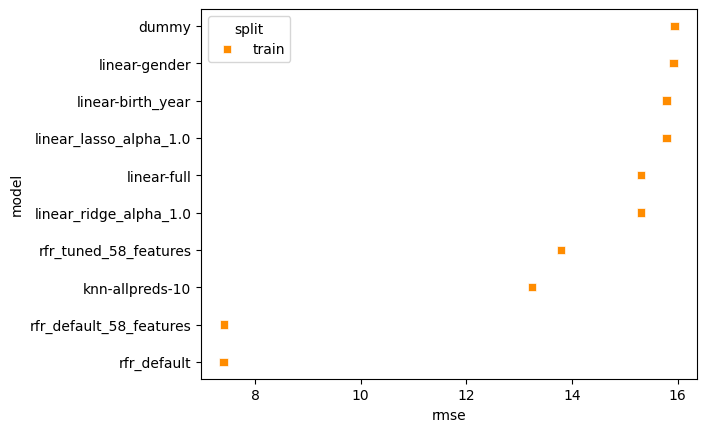

In [70]:
# plotting performances
perf_df = pd.DataFrame(performances)
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', 
                palette=['darkorange', 'grey', 'darkred'])
fig = plt.gcf() # get current figure
plt.show()

In [73]:
fig.savefig('/work/datascience_exam/output/plots/performances.jpg', bbox_inches='tight')

In [ ]:
#perf_df.to_csv('/work/datascience_exam/output/models/model_performances_v3.csv')

In [43]:
# plotting feature importances
importances = randomized_search.best_estimator_.feature_importances_
# the above computes the (normalized) total reduction of the criterion brought by that feature.

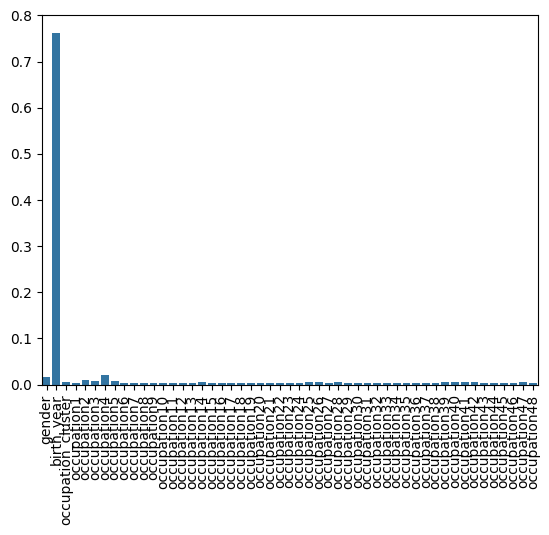

In [44]:
sns.barplot(x=X_train.columns.tolist(), y=importances, color=sns.color_palette()[0])
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
#plt.gca().set_xticks(plt.gca().get_xticks()[::2])  # Show every 10th tick # [::10]


plt.show()

### Feature selection

In [30]:
from matplotlib import pyplot
from sklearn.feature_selection import f_regression, SelectKBest


In [73]:
type(X_train)

pandas.core.frame.DataFrame

In [69]:
# feature selection using f_regression

def select_features(X_train, y_train, k_no):
    # configure to select all features or a number
    fs = SelectKBest(score_func=f_regression, k= k_no)
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    #X_test_fs = fs.transform(X_test)
    return X_train_fs, fs 

In [70]:
X_train_fs, fs = select_features(X_train, y_train, 10) # k = 'all' or chose x number of most important features

Feature 0: 1225.239204
Feature 1: 9921.619780
Feature 2: 2146.231520
Feature 3: 50.099816
Feature 4: 1304.764435
Feature 5: 467.370930
Feature 6: 5787.824785
Feature 7: 511.984302
Feature 8: 118.964952
Feature 9: 121.330197
Feature 10: 141.533798
Feature 11: 249.523181
Feature 12: 73.704463
Feature 13: 5.921109
Feature 14: 114.263532
Feature 15: 821.729485
Feature 16: 160.749735
Feature 17: 8.369026
Feature 18: 5.706026
Feature 19: 249.385076
Feature 20: 2.814521
Feature 21: 52.674707
Feature 22: 144.499804
Feature 23: 111.522017
Feature 24: 594.015891
Feature 25: 234.342221
Feature 26: 237.779519
Feature 27: 4.289003
Feature 28: 2.158343
Feature 29: 3.809985
Feature 30: 552.635925
Feature 31: 3.353557
Feature 32: 26.595922
Feature 33: 5.952956
Feature 34: 7.538964
Feature 35: 172.424523
Feature 36: 35.717541
Feature 37: 15.738743
Feature 38: 14.385934
Feature 39: 60.409047
Feature 40: 2.908049
Feature 41: 354.048050
Feature 42: 307.741966
Feature 43: 236.742005
Feature 44: 566.811591


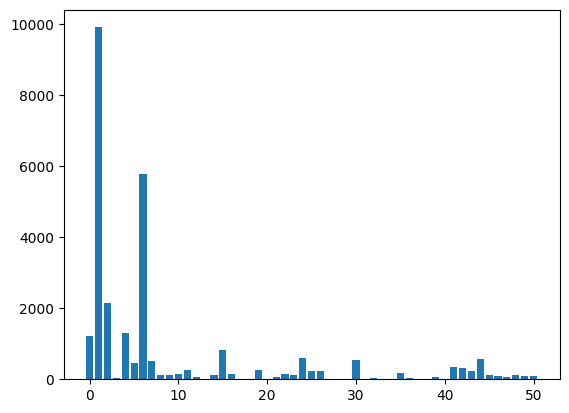

In [71]:
# what are scores for the features
for i in range(len(fs.scores_)):
 print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

In [72]:
X_train_fs.shape

(515049, 10)

### Lasso feature selection

As expected, it would be a good idea to do some feature selection. 
I'll do that using lasso

In [31]:
#from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel


In [75]:

lasso = LassoCV(cv=5, random_state=42).fit(X_train, y_train)
model = SelectFromModel(lasso, prefit=True)
X_train_selected = model.transform(X_train)


/work/datascience_exam/env/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [37]:
importances.shape
importances = randomized_search.best_estimator_.feature_importances_


(51,)

In [38]:
# try that with randomized forrest? 
model = SelectFromModel(cv_rfr_tuned, prefit=True, importance_getter = 'feature_importances_') # try this


In [39]:
X_train_selected = model.transform(X_train)
#X_train_seelcted.shape

/work/datascience_exam/env/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [41]:
X_train_selected

array([[1802, 0.03634738177061081],
       [1884, -0.018077649176120758],
       [1896, -0.0037354351952672005],
       ...,
       [1876, -0.018253348767757416],
       [1928, -0.00385521468706429],
       [1860, -0.07332148402929306]], dtype=object)

In [ ]:
# fit the model again
rfr_default = RandomForestRegressor(random_state=42)
rfr_default_fitted = rfr_default.fit(X_train_selected, y_train)

preds = rfr_default_fitted.predict(X_train_selected)
r2 = r2_score(y_train, preds)
performance = np.sqrt(mean_squared_error(y_train, preds))
#performances.append({'model': 'rfr_default_feat_select',
#                        'split': 'train',
#                         'rmse': performance.round(4),
#                         'r2': r2.round(4)})


In [45]:
performances

[{'model': 'dummy', 'split': 'train', 'rmse': 15.9491, 'r2': 0.0},
 {'model': 'linear-gender', 'rmse': 15.9302, 'r2': 0.0024},
 {'model': 'linear-birth_year', 'rmse': 15.7977, 'r2': 0.0189},
 {'model': 'linear-full', 'rmse': 15.5663, 'r2': 0.0474},
 {'model': 'linear_lasso_alpha_1.0', 'rmse': 15.769, 'r2': 0.0225},
 {'model': 'linear_ridge_alpha_1.0', 'rmse': 15.5663, 'r2': 0.0474},
 {'model': 'knn-allpreds-10', 'split': 'train', 'rmse': 14.5307, 'r2': 0.17},
 {'model': 'rfr_default', 'rmse': 13.2268, 'r2': 0.3122},
 {'model': 'random_forrest_tuned2',
  'split': 'train',
  'rmse': 13.4915,
  'r2': 0.2844},
 {'model': 'rfr_default_feat_select',
  'split': 'train',
  'rmse': 13.5097,
  'r2': 0.2825}]

In [ ]:
{'n_estimators': 100,
 'min_samples_split': 5,
 'max_features': 0.6,
 'max_depth': 10,
 'ccp_alpha': 0.01}

In [28]:
cv_rfr.best_estimator_.get_params()

{'bootstrap': True, 'ccp_alpha': 0.01, 'criterion': 'squared_error', 'max_depth': 20, 'max_features': 0.6, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

In [ ]:
cv_rfr.best_estimator_

## trying to implement regularization
We want to do that at a better model than the linear regression

In [25]:
def evaluate(model, X, y, nsplit, model_name, constant_value=None):
    ''' Evaluates the performance of a model 
    Args:
        model (sklearn.Estimator): fitted sklearn estimator
        X (np.array): predictors
        y (np.array): true outcome
        nsplit (str): name of the split
        model_name (str): string id of the model
        constant_value (int or None): relevant if the model predicts a constant
    '''
    if constant_value is not None:
        preds = np.array([constant_value] * y.shape[0])
    else:
        preds = model.predict(X)
    r2 = r2_score(y, preds)
    performance = np.sqrt(mean_squared_error(y, preds))
    performances.append({'model': model_name,
                         'split': nsplit,
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

In [21]:
models = {} # storing fitted models in the next chunk
models['linear-0.0'] = reg

In [26]:
for alpha in [0.01, 0.1, 0.2, 0.5, 1.0, 20.0, 10.0, 100.0, 1000.0]:
    for est in [Lasso, Ridge]:
        if est == Lasso:
            id = 'lasso'
        else:
            id = 'ridge'
        reg = est(alpha=alpha).fit(X_train, y_train)
        models[f'{id}-{alpha}'] = reg
        for x,y,nsplit in zip([X_train],
                            [y_train],
                            ['train']):
            evaluate(model=reg, 
                    X=x, y=y, 
                    nsplit=nsplit, 
                    model_name=f'linear-{id}-alpha-{alpha}')

/tmp/ipykernel_13432/1827935479.py:2: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False),


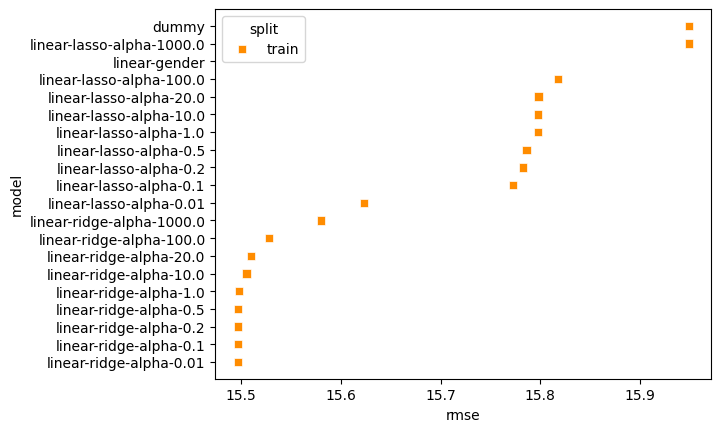

In [29]:
perf_df = pd.DataFrame(performances)
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

In [30]:
perf_df[perf_df['split']=='train'].sort_values(by='rmse', ascending=True)

,model,split,rmse,r2
4,linear-ridge-alpha-0.01,train,15.4966,0.0559
6,linear-ridge-alpha-0.1,train,15.4967,0.0559
8,linear-ridge-alpha-0.2,train,15.4968,0.0559
10,linear-ridge-alpha-0.5,train,15.4971,0.0559
12,linear-ridge-alpha-1.0,train,15.4978,0.0558
16,linear-ridge-alpha-10.0,train,15.5052,0.0549
14,linear-ridge-alpha-20.0,train,15.5098,0.0543
18,linear-ridge-alpha-100.0,train,15.5282,0.0521
20,linear-ridge-alpha-1000.0,train,15.5801,0.0457
3,linear-lasso-alpha-0.01,train,15.6232,0.0405


# Code below with attempt of CV needs to be fixed
Models need to be actually fitted. 

In [24]:
#save model 
pkl.dump(cv_rfr_obj, file=open(f'/work/datascience_exam/output/models/random_forrest_occupation.pkl', 'wb')) # save the model

In [9]:
# reload model object
with open('/work/datascience_exam/output/models/random_forrest_occupation.pkl', 'rb') as file:
    cv_rfr_obj = pkl.load(file)

In [11]:
cv_rfr_obj.best_params_

{'n_estimators': 100,
 'min_samples_split': 5,
 'max_features': 0.6,
 'max_depth': 10,
 'ccp_alpha': 0.01}

In [34]:
cv_rfr_obj.best_estimator_.get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(ccp_alpha=0.01, max_depth=10, max_features=0.6,
                      min_samples_split=5, random_state=42)>

Do random grid search with best parameters? read documentation

In [14]:
cv_rfr_tuned = cv_rfr_obj.best_estimator_

preds = cv_rfr_tuned.predict(X_train)
r2 = r2_score(y_train, preds)
performance = np.sqrt(mean_squared_error(y_train, preds))
performances.append({'model': 'random_forrest_tuned', 
                        'split': 'train',
                        'rmse': performance.round(4),
                        'r2': r2.round(4)})

In [51]:
performances 

[{'model': 'dummy', 'split': 'train', 'rmse': 15.9491, 'r2': 0.0},
 {'model': 'linear-gender', 'rmse': 15.9302, 'r2': 0.0024},
 {'model': 'linear-full', 'rmse': 15.5663, 'r2': 0.0474},
 {'model': 'random_forrest_tuned',
  'split': 'train',
  'rmse': 14.1094,
  'r2': 0.2174}]

plotting the features

Now it's time to introduce some regularization! with lasso? ridge? how to in random forrest?

Lasso can be used for feature selection (can ridge, too?)
So, try to use lasse of selecting important features and then fit the randomforest regressor to the data again

### shap - doesn't work

In [10]:
import shap

In [49]:
# load JS visualization code to notebook
shap.initjs()

In [11]:
explainer = shap.TreeExplainer(rfreg)

In [15]:
X_train.iloc[500,:]

gender                       2
birth_year                1923
occupation_cluster           3
occupation1          -0.211221
occupation2           0.062508
occupation3           0.574068
occupation4          -0.381695
occupation5          -0.174135
occupation6           0.069478
occupation7          -0.013125
occupation8           0.017718
occupation9          -0.003254
occupation10         -0.032331
occupation11         -0.029089
occupation12         -0.014242
occupation13          0.002509
occupation14         -0.008061
occupation15         -0.004581
occupation16          0.003943
occupation17          0.011421
occupation18         -0.004642
occupation19         -0.001025
occupation20         -0.005082
occupation21         -0.000737
occupation22          -0.00365
occupation23         -0.001809
occupation24         -0.003449
occupation25         -0.004927
occupation26         -0.000134
occupation27          0.001596
occupation28         -0.003191
occupation29         -0.005216
occupati

In [ ]:
# Calculate Shap values
choosen_instance = X_test.loc[[788]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

In [13]:
explainer

In [46]:
explainer = shap.TreeExplainer(cv_rfr_tuned)

In [ ]:
explainer

In [47]:
shap_values = explainer.shap_values(X_train)

: 

: 

In [ ]:
explanation = explainer(X_train)

shap_values = explanation.values

In [ ]:
shap.summery_plot(shap_values, features = X_train, feature_names=X_train.columns)

In [ ]:
# bar plot
shap.summery_plot(shap_values, features = X_train, feature_names=X_train.columns. plot_type = 'bar')
